In [ ]:
import datetime

import numpy as np
import numpy.typing as npt
import torch
from matplotlib import pyplot as plt

from src.azure_wrap.ml_client_utils import initialize_blob_service_client
from src.data.atmospheric_data import ATMOSPHERIC_DATA
from src.data.recycled_plumes.data_item import OldMultiTemporalPlumesDataItem
from src.data.recycled_plumes.sim_plumes import (
    get_gamma,
    get_radtran_lookup_tables,
    randomly_position_sim_plume,
)
from src.data.sentinel2 import SceneClassificationLabel as SCLabel
from src.data.sentinel2 import (
    Sentinel2Item,
)
from src.inference.inference_functions import (
    #     TARGET_IDX,
    obtain_data_items_4by4,
    predict,
)
from src.inference.inference_target_location import add_retrieval_to_pred, plot_prediction
from src.plotting.plotting_functions import (
    plot_frac,
)
from src.training.loss_functions import TwoPartLoss
from src.utils.parameters import MAIN_IDX, S2_BANDS
from src.utils.utils import ConcatenateSnapshots, initialize_clients, load_model_and_concatenator

/anaconda/envs/methane-cv/lib/python3.10/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/anaconda/envs/methane-cv/lib/python3.10/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [9]:
import logging

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger("azure")
logger.setLevel(logging.ERROR)

In [4]:
SC_MASK_LABELS = [
    SCLabel.NO_DATA,
    SCLabel.CLOUD_HIGH_PROBABILITY,
    SCLabel.CLOUD_MEDIUM_PROBABILITY,
    SCLabel.THIN_CIRRUS,
]
crop_size = 128
# Initialize clients
ml_client, _, _, s3_client = initialize_clients(force_msi=False)
abs_client = initialize_blob_service_client(ml_client)

Found the config file in: /config.json


# Loading simulated plumes

In [11]:
raw_enhancements = [
    np.load("/home/azureuser/localfiles/data/methane_enhancements_molpercm2/0/methane_enhancement.npy"),
    np.load("/home/azureuser/localfiles/data/methane_enhancements_molpercm2/1/methane_enhancement.npy"),
    np.load("/home/azureuser/localfiles/data/methane_enhancements_molpercm2/2/methane_enhancement.npy"),
    np.load("/home/azureuser/localfiles/data/methane_enhancements_molpercm2/3/methane_enhancement.npy"),
    np.load("/home/azureuser/localfiles/data/methane_enhancements_molpercm2/4/methane_enhancement.npy"),
]

In [12]:
def crop(padded_enhancement, min_molcm2):
    any_axis1 = np.any(padded_enhancement > min_molcm2, axis=0)
    any_axis0 = np.any(padded_enhancement > min_molcm2, axis=1)
    cropped_enhancement = padded_enhancement[any_axis0, :]
    cropped_enhancement = cropped_enhancement[:, any_axis1]
    return cropped_enhancement

In [13]:
# crop
enhancements_molcm2 = [crop(raw, min_molcm2=1e-8) for raw in raw_enhancements]

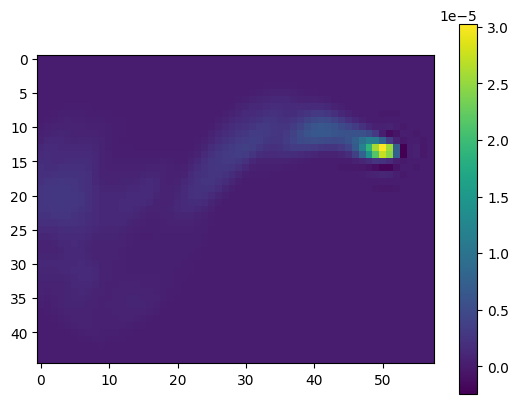

In [14]:
plt.imshow(enhancements_molcm2[0])
plt.colorbar()

# Obtaining S2 data

In [56]:
# load a tile (right next to the Permian basin, but hopefully no methane sources)
lat, lon = 33.22195, -103.98409
target_date = datetime.datetime(2024, 8, 10, tzinfo=datetime.timezone.utc)
data_item_generator = obtain_data_items_4by4(
    lat,
    lon,
    start_time=target_date - datetime.timedelta(days=10),
    end_time=target_date + datetime.timedelta(days=10),
    crop_size=crop_size,
    max_cloud_ratio=0.3,
    abs_client=abs_client,
    s3_client=s3_client,
    l1c=True,
)

In [57]:
data_items = list(data_item_generator)
# the index of the scene nearest the target date
itarget = np.argmin([abs((timestamp - target_date).total_seconds()) for (data_item, timestamp, s2_item) in data_items])

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:12<00:00,  9.10s/it]


Dates of S2 items found:
2024-07-31 17:39:11.024000+00:00
2024-08-02 17:28:59.024000+00:00
2024-08-05 17:39:09.024000+00:00
2024-08-07 17:29:01.024000+00:00
2024-08-10 17:39:01.024000+00:00
2024-08-12 17:28:59.024000+00:00
2024-08-15 17:39:09.024000+00:00
2024-08-17 17:29:01.024000+00:00


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 788.35it/s]


In [58]:
methane_free, timestamp, s2_stack = data_items[itarget]

In [69]:
timestamp

datetime.datetime(2024, 1, 20, 16, 46, 19, 24000, tzinfo=datetime.timezone.utc)

# Adding methane to Sentinel bands

In [60]:
scl_band = methane_free.crop_main[S2_BANDS.index("SCL"), :, :]
cloud_pixel_mask = Sentinel2Item.get_mask_from_scmap(SC_MASK_LABELS, scl_band)

In [ ]:
rng = np.random.default_rng(42)
enhancement = enhancements_molcm2[0]
(
    methane_enhancement_molpercm2,
    methane_enhancement_mask,
    _,
) = randomly_position_sim_plume(
    sim_plumes=[
        (enhancement, enhancement > 0),
    ],
    tile_band=methane_free.crop_main[S2_BANDS.index("B12"), :, :],
    exclusion_mask_plumes=cloud_pixel_mask,
    rng=rng,
)

In [12]:
class RadTranLookupTable:
    """
    This is a class for the radtran lookup table,
    to encapsulate and simplify its use for various applications.
    """

    def __init__(
        self,
        min_ch4: float,
        max_ch4: float,
        spacing_resolution: float,
        nB_grid_band: npt.ArrayLike,
        nB_grid_ref_band: npt.ArrayLike,
    ):
        self.min_ch4 = min_ch4
        self.max_ch4 = max_ch4
        self.spacing_resolution = spacing_resolution
        self.nB_grid_band = nB_grid_band
        self.nB_grid_ref_band = nB_grid_ref_band
        self.retrieval_grid = np.linspace(min_ch4, max_ch4, spacing_resolution)
        self.absfrac_grid = np.abs(nB_grid_band / nB_grid_ref_band - 1)

    @classmethod
    def from_params(
        cls,
        instrument: str,
        gamma: float,
        min_ch4: float,
        max_ch4: float,
        spacing_resolution: float,
    ):
        nB_grid_band, nB_grid_ref_band = get_radtran_lookup_tables(
            **ATMOSPHERIC_DATA[instrument],
            gamma=gamma,
            av_constant=AVOGADRO_CONSTANT,
            min_ch4=min_ch4,
            max_ch4=max_ch4,
            spacing_resolution=spacing_resolution,
        )
        return cls(min_ch4, max_ch4, spacing_resolution, nB_grid_band, nB_grid_ref_band)

    def lookup(self, methane_molpercm2: npt.ArrayLike) -> tuple[npt.NDArray, npt.NDArray]:
        """
        Parameters
        ----------
        methane_molpercm2: np.ArrayLike
            Methane enhancement in units of mole per cm2.
        """
        dims: Tuple = methane_molpercm2.shape
        methane_molpercm2_1d = methane_molpercm2.reshape(-1)
        assert np.max(methane_molpercm2) <= self.max_ch4
        index = np.floor((methane_molpercm2_1d / self.max_ch4) * self.spacing_resolution).astype(int)
        # gorrono plumes have elements smaller than zero, which are mapped to indeces smaller than zero
        # we correct those here
        index[np.where(index < 0)] = 0
        nB_band: np.ndarray = np.clip(self.nB_grid_band[index], 0.0, 1.0).reshape(dims)
        nB_ref_band: np.ndarray = np.clip(self.nB_grid_ref_band[index], 0.0, 1.0).reshape(dims)
        return nB_ref_band, nB_band

    def reverse_lookup(self, frac: npt.ArrayLike) -> npt.NDArray:
        index = np.searchsorted(self.absfrac_grid, np.abs(frac), side="right")
        retrieval = self.retrieval_grid[index]
        return retrieval

In [63]:
AVOGADRO_CONSTANT = 6.02214076e23
min_ch4 = 0.0
max_ch4 = 200.0 / 10000
spacing_resolution = 10000
instrument = s2_stack[MAIN_IDX].instrument
gamma = get_gamma(s2_stack[MAIN_IDX].solar_angle, s2_stack[MAIN_IDX].observation_angle)

In [64]:
instrument, gamma

('A', 2.100695442281909)

In [65]:
lookup_table = RadTranLookupTable.from_params(
    min_ch4=0.0, max_ch4=200.0 / 10000, spacing_resolution=40000, instrument=instrument, gamma=gamma
)

In [13]:
def apply_methane_absorption(
    methane_free: OldMultiTemporalPlumesDataItem,
    enhancement: np.ndarray,
    plume_file: str,
    radtran_lookup: RadTranLookupTable,
    bands: list[str],
    swir16_band_name: str,
    swir22_band_name: str,
) -> OldMultiTemporalPlumesDataItem:
    """
    Take a OldMultiTemporalPlumesDataItem and apply additional absorption in bands 11 and 12 for the concentration of methane specified in `retrieval`.

    This creates a new modified OldMultiTemporalPlumesDataItem.
    """
    index_swir16 = bands.index(swir16_band_name)
    index_swir22 = bands.index(swir22_band_name)

    orig_swir16 = methane_free.orig_swir16
    orig_swir22 = methane_free.orig_swir22

    assert orig_swir16.shape == enhancement.shape
    band_frac_offset = 10.0
    offset_swir16 = orig_swir16 + band_frac_offset
    offset_swir22 = orig_swir22 + band_frac_offset

    nB11, nB12 = radtran_lookup.lookup(enhancement)
    sim_swir16, sim_swir22 = nB11 * offset_swir16, nB12 * offset_swir22

    # calculate FRAC from the simulated bands
    band_ratio = offset_swir22 / offset_swir16
    sim_band_ratio = sim_swir22 / sim_swir16
    reference_frac = (sim_band_ratio - band_ratio) / band_ratio
    # now remove the offset from the simulated bands and clip to zero
    # (otherwise we're giving the neural network information
    #  that wouldn't actually be present in a real image)
    np.clip(sim_swir16 - band_frac_offset, a_min=0.0, a_max=None, out=sim_swir16)
    np.clip(sim_swir22 - band_frac_offset, a_min=0.0, a_max=None, out=sim_swir22)
    # and also round to the nearest integer, again
    # so the neural network can't use non-integer values
    # as a way to detect methane
    np.round(sim_swir16, decimals=0, out=sim_swir16)
    np.round(sim_swir22, decimals=0, out=sim_swir22)
    # Modify the main crop array's band 11 and 12
    crop_main = methane_free.crop_main.copy()
    crop_main[index_swir16] = sim_swir16
    crop_main[index_swir22] = sim_swir22

    plume_item = OldMultiTemporalPlumesDataItem(
        crop_earlier=methane_free.crop_earlier,
        crop_before=methane_free.crop_before,
        crop_main=crop_main,
        orig_swir16=methane_free.orig_swir16,
        orig_swir22=methane_free.orig_swir22,
        target_frac=1 - (1 - methane_free.target_frac) * (1 - reference_frac.astype(np.float32)),
        mask_earlier=methane_free.mask_earlier,
        mask_before=methane_free.mask_before,
        mask_main=methane_free.mask_main,
        granule_item_ids=methane_free.granule_item_ids,
        plume_files=[plume_file],
        bands=methane_free.bands,
        size=methane_free.size,
        crop_x=methane_free.crop_x,
        crop_y=methane_free.crop_y,
        main_cloud_ratio=methane_free.main_cloud_ratio,
    )
    return plume_item

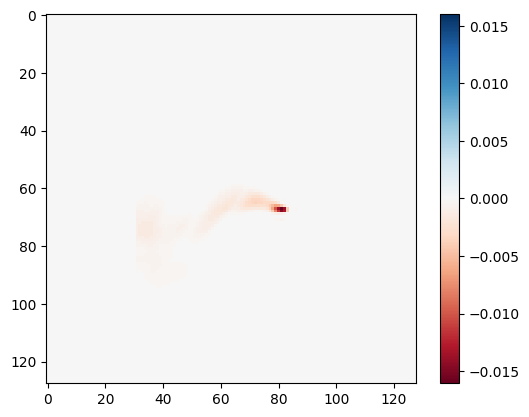

In [67]:
plume_item = apply_methane_absorption(
    methane_free,
    methane_enhancement_molpercm2,
    plume_file="plume0",
    radtran_lookup=lookup_table,
    bands=S2_BANDS,
    swir16_band_name="B11",
    swir22_band_name="B12",
)
plot_frac(torch.Tensor(plume_item.target_frac))
plt.colorbar()

In [68]:
methane_enhancement_molpercm2.min(), methane_enhancement_molpercm2.max()

(-2.4489983762962987e-06, 3.0211184973321066e-05)

# Detecting methane with CV model

In [70]:
# load the model from an experiment
# Note: this sometimes gets stuck, it should only take a few seconds
# If that happens, just interrupt the kernel and run the cell again.
# https://learn.microsoft.com/en-us/azure/machine-learning/how-to-manage-models-mlflow?view=azureml-api-2#loading-models-from-registry

model, band_concatenator, training_params = load_model_and_concatenator("models:/torchgeo_pwr_unet/548", device="cpu")
lossFn = TwoPartLoss(
    binary_threshold=training_params["binary_threshold"], MSE_multiplier=training_params["MSE_multiplier"]
)

2024-11-25 21:32:58 [WARNING] Retrying (Retry(total=4, connect=5, read=4, redirect=5, status=5)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='westeurope.api.azureml.ms', port=443): Read timed out. (read timeout=120)")': /mlflow/v2.0/subscriptions/6e71ce37-b9fe-4c43-942b-cf0f7e78c8ab/resourceGroups/orbio-ml-rg/providers/Microsoft.MachineLearningServices/workspaces/orbio-ml-ml-workspace/api/2.0/mlflow/model-versions/get-download-uri?name=torchgeo_pwr_unet&version=548 (connectionpool.py:870)
2024-11-25 21:32:59 [INFO] Parsing artifact uri azureml://westeurope.api.azureml.ms/mlflow/v2.0/subscriptions/6e71ce37-b9fe-4c43-942b-cf0f7e78c8ab/resourceGroups/orbio-ml-rg/providers/Microsoft.MachineLearningServices/workspaces/orbio-ml-ml-workspace/experiments/f5802c51-b4d5-477b-ac50-9f432df36215/runs/lime_cassava_7688pblgf8/artifacts/torchgeo_pwr_unet (utils.py:172)
2024-11-25 21:32:59 [INFO] Artifact uri azureml://westeurope.api.azureml.ms/mlflow/v2.0/subscriptions/6e71c

2024/11/25 21:33:02 WARNING mlflow.pytorch: Stored model version '2.2.1' does not match installed PyTorch version '2.4.1+cpu'
2024-11-25 21:33:02 [INFO] NOTE: Model was not saved with its training parameters, so we are using the defaults that were most likely used. (utils.py:146)


In [71]:
pred_dict = predict(
    model=model, device="cpu", band_concatenator=band_concatenator, recycled_item=plume_item, lossFn=lossFn
)
# NOTE: predict stores the 4D arrays for each prediction. We squeeze in the plotting fns where necessary

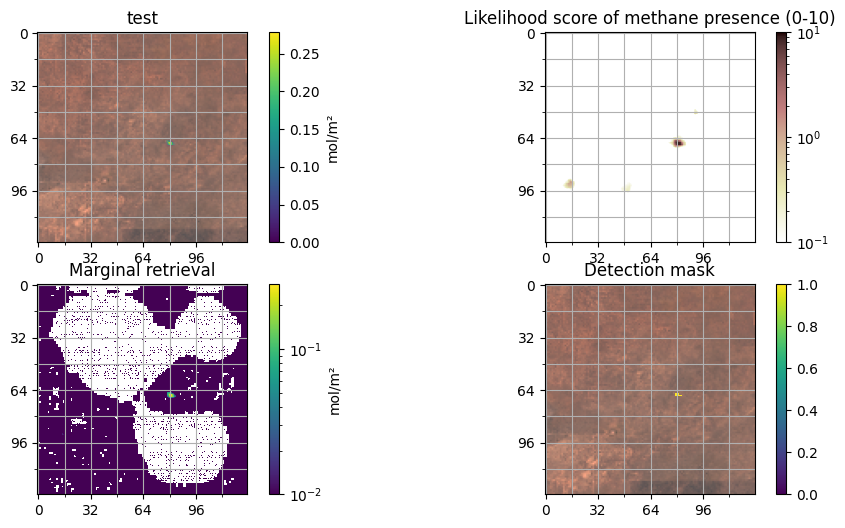

In [72]:
plt.figure(figsize=(12, 6))
# NOTE: it seems like plot_prediction requires the retrieval to be added to pred_dict. So we run that fn first
main_s2_item = s2_stack[MAIN_IDX]
pred = add_retrieval_to_pred(pred_dict, main_s2_item)
plot_prediction(pred, "test")

In [73]:
plume_mask = plume_item.target_frac < training_params["binary_threshold"]

if abs(plume_item.target_frac.min()) < float(lossFn.binary_threshold):
    # plume is not detectable
    max_likelihood_score = 0.0
plume_mask = np.abs(plume_item.target_frac) >= float(lossFn.binary_threshold)
max_likelihood_score = pred["binary_probability"][plume_mask].max() * 10
print(f"Maximum likelihood score in plume mask: {max_likelihood_score:.3f}/10")

Maximum likelihood score in plume mask: 9.181/10


# Range of emission intensities

In [88]:
emission_rates = np.concatenate(
    (np.arange(100, 2000, 100), np.arange(2000, 11000, 1000)),
)
emission_rates

array([  100,   200,   300,   400,   500,   600,   700,   800,   900,
        1000,  1100,  1200,  1300,  1400,  1500,  1600,  1700,  1800,
        1900,  2000,  3000,  4000,  5000,  6000,  7000,  8000,  9000,
       10000])

In [14]:
def max_lik_by_emission(
    methane_free: OldMultiTemporalPlumesDataItem,
    enhancement_molpercm2: npt.ArrayLike,
    base_emissions_rate: float,
    scaled_emissions_rate: float,
    radtran_lookup: RadTranLookupTable,
    model: torch.nn,
    band_concatenator: ConcatenateSnapshots,
    lossFn: TwoPartLoss,
    bands: list[str],
    swir16_band_name: str,
    swir22_band_name: str,
) -> float:
    """
    Given a methane-free scene and a methane enhancement (plume in a particular position)
    to be inserted into the scene, obtain the maximum likelihood over the plume's footprint.

    Parameters
    ----------
    methane_free : OldMultiTemporalPlumesDataItem
        The data item without any plumes inserted
    enhancement_molpercm2 : npt.ArrayLike
        The methane enhancement in mol/cm2. The shape of this raster needs to match that of
        the methane-free crop (normally 128x128)
    base_emissions_rate : float
        The original emission rate used to simulate enhancement_molpercm2
        (1000 kg/hr for the Gorroño plumes)
    scaled_emissions_rate: float
        The emission rate we want to simulate under. The original plume will be scaled up
        or down to match the scaled emissions rate.
    radtran_lookup: RadTranLookupTable
        The pre-computed radtran lookup table for this Sentinel 2 scene.
    model: torch.nn
        The pytorch model for CV predictions.
    band_concatenator: ConcatenateSnapshots
        The parametrised concatenator so we know how to pre-process the data
        to pass into the model for a prediction.
    lossFn: TwoPartLoss
        The loss function used for training the model.
    """
    scaled_enhancement = enhancement_molpercm2 * scaled_emissions_rate / base_emissions_rate
    plume_item = apply_methane_absorption(
        methane_free,
        scaled_enhancement,
        plume_file="plume0",
        radtran_lookup=radtran_lookup,
        bands=bands,
        swir16_band_name=swir16_band_name,
        swir22_band_name=swir22_band_name,
    )
    pred_dict = predict(
        model=model, device="cpu", band_concatenator=band_concatenator, recycled_item=plume_item, lossFn=lossFn
    )
    if abs(plume_item.target_frac.min()) < float(lossFn.binary_threshold):
        # plume is not detectable
        return 0.0, {}
    plume_mask = np.abs(plume_item.target_frac) >= float(lossFn.binary_threshold)
    max_likelihood_score = pred_dict["binary_probability"].squeeze()[plume_mask].max() * 10
    return float(max_likelihood_score), pred_dict

In [90]:
max_lik_by_emission(
    methane_free,
    methane_enhancement_molpercm2,
    base_emissions_rate=1000.0,
    scaled_emissions_rate=1000.0,
    radtran_lookup=lookup_table,
    model=model,
    band_concatenator=band_concatenator,
    lossFn=lossFn,
    bands=S2_BANDS,
    swir16_band_name="B11",
    swir22_band_name="B12",
)

0.4408046305179596

In [91]:
%%time
max_lik_arr = [
    max_lik_by_emission(
        methane_free,
        methane_enhancement_molpercm2,
        base_emissions_rate=1000.0,
        scaled_emissions_rate=emissions,
        radtran_lookup=lookup_table,
        model=model,
        band_concatenator=band_concatenator,
        lossFn=lossFn,
        bands=S2_BANDS,
        swir16_band_name="B11",
        swir22_band_name="B12",
    )
    for emissions in emission_rates
]

CPU times: user 3.68 s, sys: 30.3 ms, total: 3.71 s
Wall time: 1.95 s


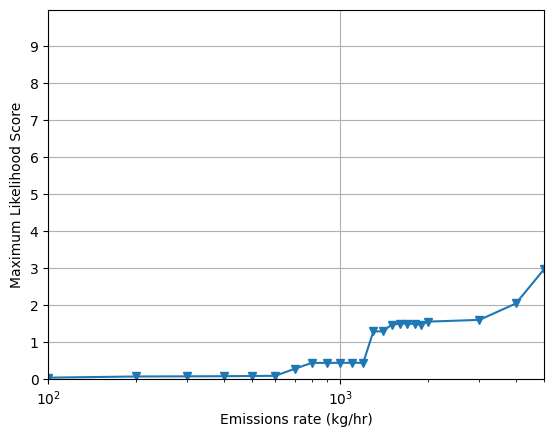

In [92]:
plt.plot(emission_rates, max_lik_arr, "-v")
plt.xlabel("Emissions rate (kg/hr)")
plt.ylabel("Maximum Likelihood Score")
plt.ylim(0, 10)
plt.xlim(100, 5000)
plt.xscale("log")
plt.yticks(range(10))
plt.grid()

## Randomizing position and rotation

In [93]:
for i, enhancement in enumerate(enhancements_molcm2):
    print(f"Maximum enhancement in Gorroño plume {i}: {enhancement.max()*10000:.3f} mol/m2")

Maximum enhancement in Gorroño plume 0: 0.302 mol/m2
Maximum enhancement in Gorroño plume 1: 0.108 mol/m2
Maximum enhancement in Gorroño plume 2: 0.112 mol/m2
Maximum enhancement in Gorroño plume 3: 0.127 mol/m2
Maximum enhancement in Gorroño plume 4: 0.487 mol/m2


In [ ]:
%%time
rng = np.random.default_rng(1)
nsims = 100
likelihood_curves = []
for _ in tqdm(range(nsims)):
    # pick one of the 5 random Gorroño plumes
    random_plume_index = rng.choice(np.arange(len(enhancements_molcm2)))
    enhancement = enhancements_molcm2[random_plume_index]
    # randomly position and rotate
    (
        methane_enhancement_molpercm2,
        methane_enhancement_mask,
        _,
    ) = randomly_position_sim_plume(
        sim_plumes=[
            (enhancement, enhancement > 0),
        ],
        tile_band=methane_free.crop_main[S2_BANDS.index("B12"), :, :],
        exclusion_mask_plumes=cloud_pixel_mask,
        rng=rng,
    )
    # then get likelihood as a function of emissions rate
    max_lik_arr = [
        max_lik_by_emission(
            methane_free,
            methane_enhancement_molpercm2,
            base_emissions_rate=1000.0,
            scaled_emissions_rate=emissions,
            radtran_lookup=lookup_table,
            model=model,
            band_concatenator=band_concatenator,
            lossFn=lossFn,
            bands=S2_BANDS,
            swir16_band_name="B11",
            swir22_band_name="B12",
        )
        for emissions in emission_rates
    ]
    # save
    likelihood_curves.append(max_lik_arr)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:18<00:00,  1.98s/it]

CPU times: user 6min 27s, sys: 1.9 s, total: 6min 29s
Wall time: 3min 18s


In [95]:
likelihood_curves_arr = np.stack(likelihood_curves)

''

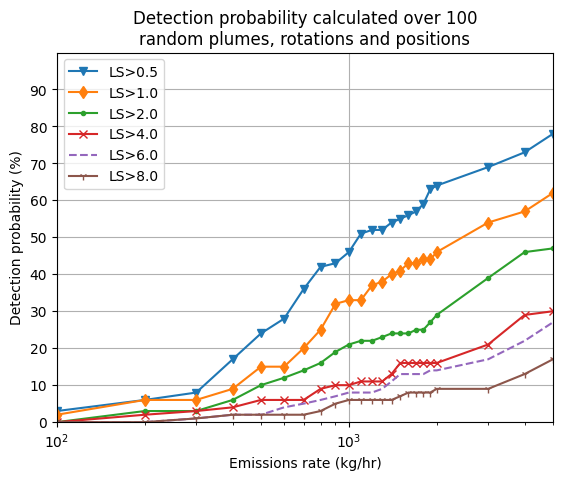

In [96]:
styles = ["-v", "-d", ".-", "-x", "--", "-1"]
for i, ls_thresh in enumerate([0.5, 1.0, 2.0, 4.0, 6.0, 8.0]):
    detection_prob_for_thresh = (likelihood_curves_arr > ls_thresh).mean(axis=0)
    plt.plot(emission_rates, detection_prob_for_thresh * 100, styles[i], label=f"LS>{ls_thresh:.1f}")
plt.xlabel("Emissions rate (kg/hr)")
plt.ylabel("Detection probability (%)")
plt.ylim(0, 100)
plt.xlim(100, 5000)
plt.xscale("log")
plt.yticks(range(0, 100, 10))
plt.grid()
plt.legend(loc="upper left")
plt.title(f"Detection probability calculated over {nsims}\nrandom plumes, rotations and positions")
;

''

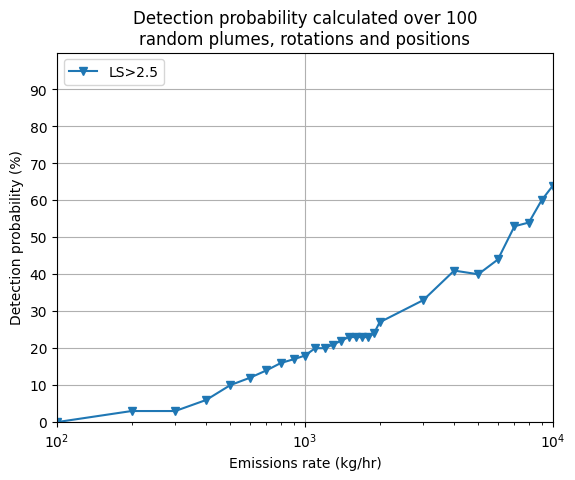

In [97]:
styles = ["-v"]
for i, ls_thresh in enumerate([2.5]):
    detection_prob_for_thresh = (likelihood_curves_arr > ls_thresh).mean(axis=0)
    plt.plot(emission_rates, detection_prob_for_thresh * 100, styles[i], label=f"LS>{ls_thresh:.1f}")
plt.xlabel("Emissions rate (kg/hr)")
plt.ylabel("Detection probability (%)")
plt.ylim(0, 100)
plt.xlim(100, 10000)
plt.xscale("log")
plt.yticks(range(0, 100, 10))
plt.grid()
plt.legend(loc="upper left")
plt.title(f"Detection probability calculated over {nsims}\nrandom plumes, rotations and positions")
;

# Export array

In [ ]:
%%time
rng = np.random.default_rng(1)
nsims = 200
positioned_enhancements = []
for _ in tqdm(range(nsims)):
    # pick one of the 5 random Gorroño plumes
    random_plume_index = rng.choice(np.arange(len(enhancements_molcm2)))
    enhancement = enhancements_molcm2[random_plume_index]
    # randomly position and rotate
    (
        methane_enhancement_molpercm2,
        methane_enhancement_mask,
        _,
    ) = randomly_position_sim_plume(
        sim_plumes=[
            (enhancement, enhancement > 0),
        ],
        tile_band=methane_free.crop_main[S2_BANDS.index("B12"), :, :],
        exclusion_mask_plumes=cloud_pixel_mask,
        rng=rng,
    )
    positioned_enhancements.append(methane_enhancement_molpercm2)

100%|██████████| 200/200 [00:00<00:00, 5041.08it/s]

CPU times: user 36.8 ms, sys: 8.05 ms, total: 44.9 ms
Wall time: 44.4 ms


In [32]:
positioned_enhancements_arr = np.stack(positioned_enhancements).shape
np.save("randomly_positioned_plumes.npy", positioned_enhancements_arr)

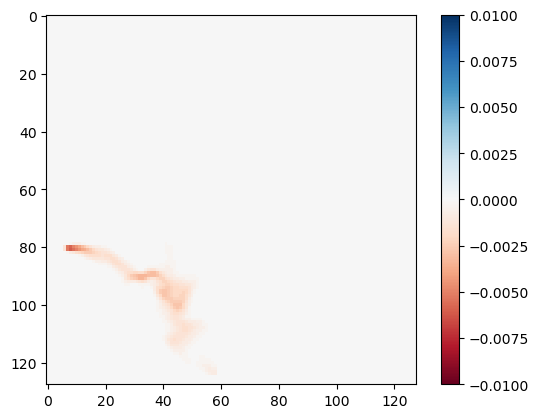

In [33]:
plume_item = apply_methane_absorption(
    methane_free,
    positioned_enhancements[0],
    plume_file="plume0",
    radtran_lookup=lookup_table,
    bands=S2_BANDS,
    swir16_band_name="B11",
    swir22_band_name="B12",
)
plot_frac(torch.Tensor(plume_item.target_frac))
plt.colorbar()

In [34]:
sample_b11_b12 = np.stack(
    (
        plume_item.crop_main[S2_BANDS.index("B11")],
        plume_item.crop_main[S2_BANDS.index("B12")],
    )
)

In [35]:
1 - (sample_b11_b12[1, :, :] / plume_item.orig_swir22).min()

0.007199177236887233

In [36]:
np.save("sample_b11_b12.npy", sample_b11_b12)